In [1]:
import pandas as pd
import numpy as np
import nltk
import re
from gensim import utils
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("questions.csv")

In [3]:
df.shape

(404351, 6)

In [4]:
df.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [5]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

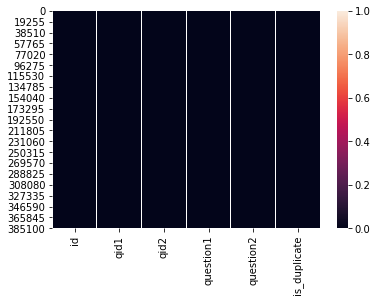

In [6]:
sns.heatmap(df.isnull())

In [7]:
df.dropna(inplace=True)

In [8]:
df.is_duplicate.value_counts()

0    255042
1    149306
Name: is_duplicate, dtype: int64

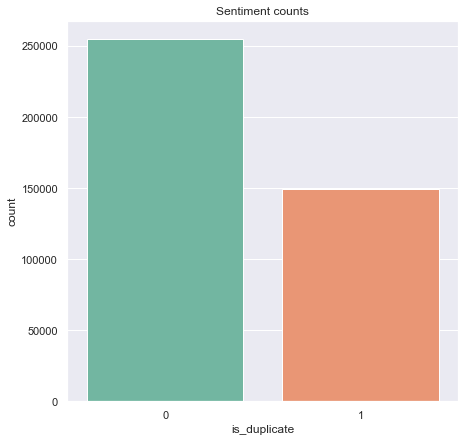

In [9]:
sns.set()
plt.figure(figsize=(7,7))
sns.countplot(x=df.is_duplicate,palette='Set2')
plt.title("Sentiment counts")
plt.show()

In [10]:
stopwords = set(nltk.corpus.stopwords.words('english'))

In [11]:
#process the data
def process_data(text):
        text = re.sub(r"[^A-Za-z0-9(),!.?\'`]", " ", text )
        text = re.sub(r"\'s", " 's ", text )
        text = re.sub(r"\'ve", " 've ", text )
        text = re.sub(r"n\'t", " 't ", text )
        text = re.sub(r"\'re", " 're ", text )
        text = re.sub(r"\'d", " 'd ", text )
        text = re.sub(r"\'ll", " 'll ", text )
        text = re.sub(r",", " ", text )
        text = re.sub(r"\.", " ", text )
        text = re.sub(r"!", " ", text )
        text = re.sub(r"\(", " ( ", text )
        text = re.sub(r"\)", " ) ", text )
        text = re.sub(r"\?", " ", text )
        text = re.sub(r"\s{2,}", " ", text )
        lemmatizer = nltk.WordNetLemmatizer()
        tokens=text.lower().split()
        tokens= [lemmatizer.lemmatize(w) for w in tokens if w not in stopwords]
        data=" ".join(tokens)
        return data

In [12]:
df.question1=df.question1.apply(lambda data: process_data(data))

In [13]:
df.question2=df.question2.apply(lambda data: process_data(data))

In [14]:
# Function to report the quality of the model
def performance_report(value, score_list):
    # the value (0-1) is the cosine similarity score to determine if a pair of questions
    # have the same meaning or not.
    scores = []
    for score in score_list:
        if score >= value:
            scores.append(1)
        else:
            scores.append(0)

    accuracy = accuracy_score(df.is_duplicate, scores) * 100
    print("Accuracy score is {}%.".format(round(accuracy),1))
    print()
    print("Confusion Matrix:")
    print(confusion_matrix(df.is_duplicate, scores))
    print()
    print("Classification Report:")
    print(classification_report(df.is_duplicate, scores))

# 1.TfidfVectorizer

In [15]:
vectorizer = TfidfVectorizer()
def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]

In [16]:
Tfidf_scores = []
for i in range(len(df.question1)):
    try:
        score = cosine_sim(df.question1[i], df.question2[i])
    except:
        pass
    Tfidf_scores.append(score)

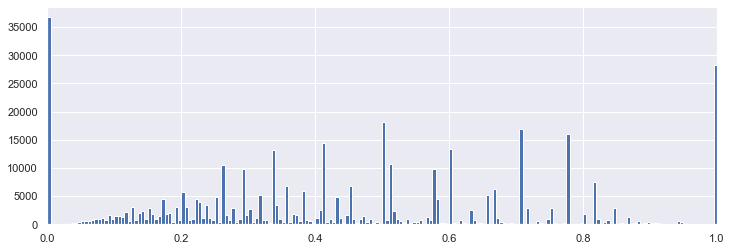

In [17]:
# Plot the scores
plt.figure(figsize=(12,4))
plt.hist(Tfidf_scores, bins = 200)
plt.xlim(0,1)
plt.show()

In [18]:
performance_report(0.8, Tfidf_scores)

Accuracy score is 62.0%.

Confusion Matrix:
[[228431  26611]
 [128247  21059]]

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.90      0.75    255042
           1       0.44      0.14      0.21    149306

    accuracy                           0.62    404348
   macro avg       0.54      0.52      0.48    404348
weighted avg       0.57      0.62      0.55    404348



# 2. Doc2Vec

In [19]:
labeled_questions=[]

for i in range(len(df.question1)):
    # Question strings need to be separated into words
    # Each question needs a unique label
    try:
        labeled_questions.append(TaggedDocument(df.question1[i].split(), df[df.index == i].qid1))
        labeled_questions.append(TaggedDocument(df.question2[i].split(), df[df.index == i].qid2))
    except:
        pass

In [20]:
model = Doc2Vec(dm = 1, min_count=1, window=10, vector_size=150, sample=1e-4, negative=10)
model.build_vocab(labeled_questions)

In [21]:
for epoch in range(5):
    model.train(labeled_questions,epochs=model.epochs,total_examples=model.corpus_count)
    print("Epoch #{} is complete.".format(epoch+1))

Epoch #1 is complete.
Epoch #2 is complete.
Epoch #3 is complete.
Epoch #4 is complete.
Epoch #5 is complete.


In [22]:
questions1_split = []
for question in df.question1:
    questions1_split.append(question.split())
    
questions2_split = []
for question in df.question2:
    questions2_split.append(question.split())

In [23]:
doc2vec_scores = []
for i in range(len(questions1_split)):
    # n_similarity computes the cosine similarity in Doc2Vec
    try:
        score = model.wv.n_similarity(questions1_split[i],questions2_split[i])
    except:
        pass
    doc2vec_scores.append(score)

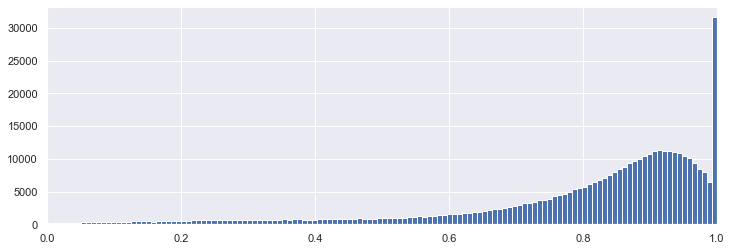

In [24]:
# Plot the scores
plt.figure(figsize=(12,4))
plt.hist(doc2vec_scores, bins = 200)
plt.xlim(0,1)
plt.show()

In [25]:
performance_report(0.9, doc2vec_scores)

Accuracy score is 67.0%.

Confusion Matrix:
[[185916  69126]
 [ 62764  86542]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74    255042
           1       0.56      0.58      0.57    149306

    accuracy                           0.67    404348
   macro avg       0.65      0.65      0.65    404348
weighted avg       0.68      0.67      0.68    404348

